# Implementasi Model Deep Learning CNN dan MLP untuk CIFAR-10 dengan PyTorch

##Tugas:
1. Buat model Deep learning CNN dan MLP (PyTorch). Ambil datasets dari torchvision.datasets
2. Gunakan Matriks Evaluasi (Akurasi, Presisi, Recall, F1Score, AUC, ROC)
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Akurasi pada Training dan Testing Set Minimal Sebesar 75%. Untuk model MLP Vanila bebas mendapat akurasi berapapun
5. Disarankan untuk menggunakan Google Colab dengan T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.

In [1]:
# Instalasi library yang diperlukan
!pip install -q torch torchvision matplotlib scikit-learn pandas seaborn

# Import library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Set random seed untuk reproduktibilitas
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00


In [2]:
# Import PyTorch Libraries dan cek ketersediaan GPU
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set random seed untuk PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Cek ketersediaan GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"PyTorch menggunakan device: {device}")
if torch.cuda.is_available():
    print(f"Nama GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memori GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch menggunakan device: cuda:0
Nama GPU: Tesla T4
Memori GPU: 15.83 GB


## 1. Persiapan Dataset CIFAR-10

CIFAR-10 adalah dataset yang terdiri dari 60.000 gambar berwarna dengan resolusi 32x32 pixel, dibagi menjadi 10 kelas: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, dan truck. Dataset dibagi menjadi 50.000 gambar untuk pelatihan dan 10.000 gambar untuk pengujian.

In [3]:
# Definisi transformasi data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Parameter batch size
batch_size = 128

# Memuat dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Nama kelas CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Menampilkan informasi dataset
print(f"Jumlah data pelatihan: {len(trainset)}")
print(f"Jumlah data pengujian: {len(testset)}")
print(f"Jumlah kelas: {len(classes)}")
print(f"Kelas: {classes}")
print(f"Ukuran gambar: {trainset[0][0].shape}")

100%|██████████| 170M/170M [00:19<00:00, 8.84MB/s]


Jumlah data pelatihan: 50000
Jumlah data pengujian: 10000
Jumlah kelas: 10
Kelas: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Ukuran gambar: torch.Size([3, 32, 32])


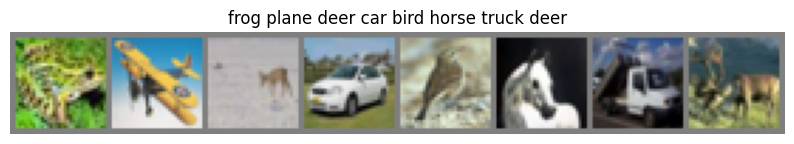

In [4]:
# Visualisasi beberapa gambar dari dataset
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Ambil beberapa gambar secara acak
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Tampilkan gambar
plt.figure(figsize=(10, 4))
imshow(torchvision.utils.make_grid(images[:8]))
plt.title(' '.join(f'{classes[labels[j]]}' for j in range(8)))
plt.show()

## 2. Implementasi Model CNN

### Penjelasan Arsitektur Model CNN:
1. **Convolutional Layers**:
   - Mengekstrak fitur spasial dari gambar
   - Menggunakan kernel 3x3 dengan padding=1 untuk mempertahankan dimensi spasial
   - Meningkatkan jumlah filter (32 → 64 → 128) untuk menangkap fitur yang lebih kompleks

2. **BatchNormalization**:
   - Menstabilkan dan mempercepat pembelajaran dengan menormalkan aktivasi
   - Membantu mengatasi masalah internal covariate shift

3. **MaxPooling**:
   - Mengurangi dimensi spasial (downsampling)
   - Membantu mencapai invariansi translasi

4. **Fully Connected Layers**:
   - Mengklasifikasikan fitur yang diekstrak
   - Layer terakhir memiliki 10 neuron (sesuai jumlah kelas CIFAR-10)

5. **Dropout**:
   - Mencegah overfitting dengan menonaktifkan neuron secara acak selama pelatihan
   - Probabilitas dropout 0.25 (25% neuron dinonaktifkan)

In [5]:
# Model CNN untuk CIFAR-10
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        # Input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Output: 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output: 64x32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output: 128x32x32

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Output setelah 3 conv+pool: 128x4x4

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional blocks
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv -> BatchNorm -> ReLU -> MaxPool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv -> BatchNorm -> ReLU -> MaxPool

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Inisialisasi model CNN
cnn_model = CNN().to(device)
# Tampilkan ringkasan model
print(cnn_model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## 3. Implementasi Model MLP (Multi-Layer Perceptron)

### Penjelasan Arsitektur Model MLP:
1. **Flatten Layer**:
   - Mengubah input gambar 3x32x32 menjadi vektor 1D (3072 elemen)

2. **Fully Connected Layers**:
   - Lapisan pertama: 3072 → 1024 neuron
   - Lapisan kedua: 1024 → 512 neuron
   - Lapisan output: 512 → 10 neuron (sesuai jumlah kelas CIFAR-10)

3. **ReLU Activation**:
   - Fungsi aktivasi non-linear pada hidden layers
   - Memungkinkan jaringan mempelajari pola kompleks

4. **Dropout**:
   - Mencegah overfitting dengan menonaktifkan 25% neuron secara acak selama pelatihan

In [6]:
# Model MLP (Vanilla) untuk CIFAR-10
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Flatten input 3x32x32 = 3072
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Flatten input
        x = x.view(-1, 3 * 32 * 32)

        # Fully connected layers dengan ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Inisialisasi model MLP
mlp_model = MLP().to(device)
# Tampilkan ringkasan model
print(mlp_model)

MLP(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## 4. Fungsi untuk Pelatihan dan Evaluasi Model

### Pelatihan Model:
- Menggunakan **Cross Entropy Loss**
- Optimisasi dengan **Adam Optimizer**
- Learning rate: **0.001**
- Jumlah epoch: **15**

### Evaluasi Model:
- **Akurasi**: Proporsi prediksi yang benar
- **Presisi**: Proporsi prediksi positif yang benar
- **Recall**: Proporsi positif sebenarnya yang diidentifikasi dengan benar
- **F1 Score**: Rata-rata harmonik dari presisi dan recall
- **ROC Curve dan AUC**: Mengukur kemampuan model untuk membedakan kelas

In [7]:
# Fungsi untuk melatih model
def train_model(model, criterion, optimizer, num_epochs=15):
    model.to(device)
    train_losses = []
    train_accs = []

    # Untuk tracking waktu
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistik
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print progress setiap 100 batch
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')

        # Menghitung loss dan accuracy rata-rata untuk epoch ini
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Print epoch stats
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    # Print total training time
    total_time = time.time() - start_time
    print(f'Training selesai dalam {total_time:.2f} detik')

    return train_losses, train_accs

In [8]:
# Fungsi untuk evaluasi model
def evaluate_model(model, testloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    # Untuk tracking waktu
    start_time = time.time()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Mengumpulkan prediksi dan label
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Menghitung metrik evaluasi
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Membuat confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # ROC curve dan AUC (One-vs-Rest)
    # Perlu mengkonversi output ke format one-hot untuk ROC/AUC
    model.eval()
    probs = []
    with torch.no_grad():
        for data in testloader:
            images, _ = data
            images = images.to(device)
            output = model(images)
            probs.append(F.softmax(output, dim=1).cpu().numpy())

    probs = np.vstack(probs)

    # Menghitung ROC AUC untuk setiap kelas (one-vs-rest)
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menghitung rata-rata AUC
    macro_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Macro ROC AUC: {macro_roc_auc:.4f}')

    # Print total evaluation time
    total_time = time.time() - start_time
    print(f'Evaluasi selesai dalam {total_time:.2f} detik')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': macro_roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc_per_class': roc_auc
    }

## 5. Pelatihan dan Evaluasi Model CNN

In [9]:
# Pelatihan model CNN
print("Training model CNN...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_train_losses, cnn_train_accs = train_model(cnn_model, criterion, optimizer, num_epochs=15)

Training model CNN...
Epoch [1/15], Step [100/391], Loss: 1.3687
Epoch [1/15], Step [200/391], Loss: 1.1193
Epoch [1/15], Step [300/391], Loss: 0.8574
Epoch 1/15, Loss: 1.2708, Accuracy: 54.08%
Epoch [2/15], Step [100/391], Loss: 0.8645
Epoch [2/15], Step [200/391], Loss: 0.9543
Epoch [2/15], Step [300/391], Loss: 0.8586
Epoch 2/15, Loss: 0.8878, Accuracy: 68.58%
Epoch [3/15], Step [100/391], Loss: 0.7372
Epoch [3/15], Step [200/391], Loss: 0.7880
Epoch [3/15], Step [300/391], Loss: 0.9052
Epoch 3/15, Loss: 0.7488, Accuracy: 73.57%
Epoch [4/15], Step [100/391], Loss: 0.5484
Epoch [4/15], Step [200/391], Loss: 0.5895
Epoch [4/15], Step [300/391], Loss: 0.7670
Epoch 4/15, Loss: 0.6532, Accuracy: 77.12%
Epoch [5/15], Step [100/391], Loss: 0.6637
Epoch [5/15], Step [200/391], Loss: 0.4565
Epoch [5/15], Step [300/391], Loss: 0.6495
Epoch 5/15, Loss: 0.5812, Accuracy: 79.63%
Epoch [6/15], Step [100/391], Loss: 0.5369
Epoch [6/15], Step [200/391], Loss: 0.5117
Epoch [6/15], Step [300/391], Lo

In [10]:
# Evaluasi model CNN
print("\nEvaluasi model CNN pada data test:")
cnn_metrics = evaluate_model(cnn_model, testloader, classes)


Evaluasi model CNN pada data test:
Accuracy: 0.7899
Precision: 0.7967
Recall: 0.7899
F1 Score: 0.7879
Macro ROC AUC: 0.9765
Evaluasi selesai dalam 5.01 detik


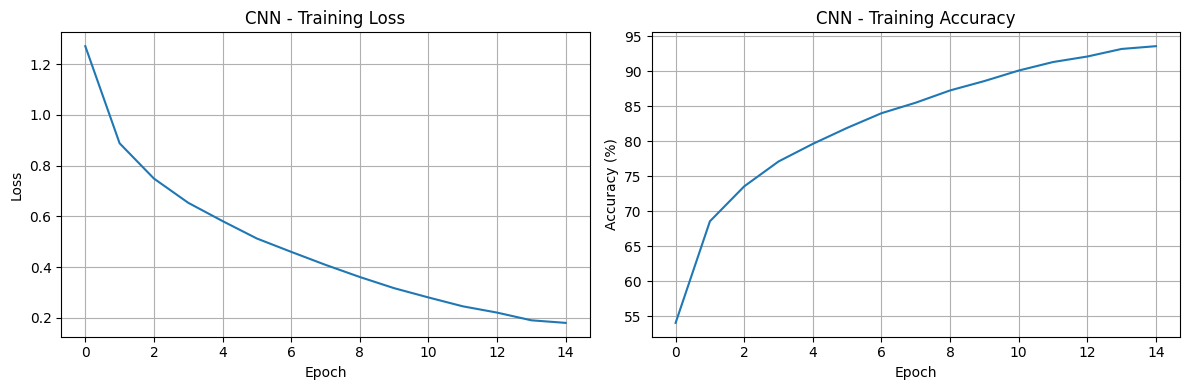

In [11]:
# Fungsi untuk plot hasil training
def plot_training_results(train_losses, train_accs, model_name):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs)
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot hasil training CNN
plot_training_results(cnn_train_losses, cnn_train_accs, "CNN")

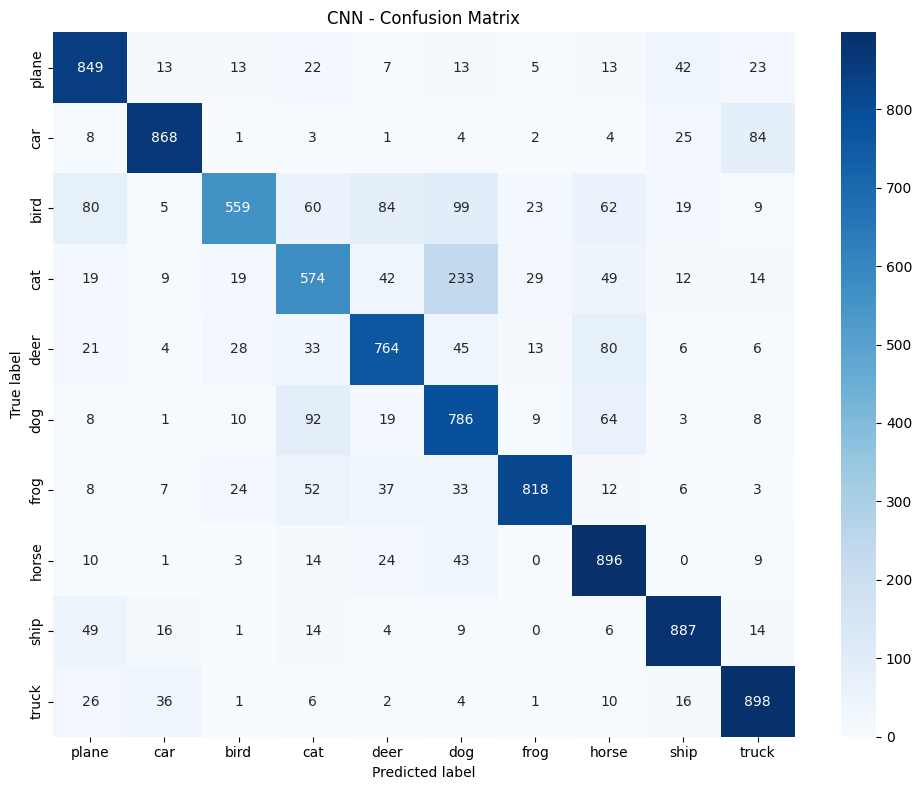

In [12]:
# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix CNN
plot_confusion_matrix(cnn_metrics['confusion_matrix'], classes, "CNN")

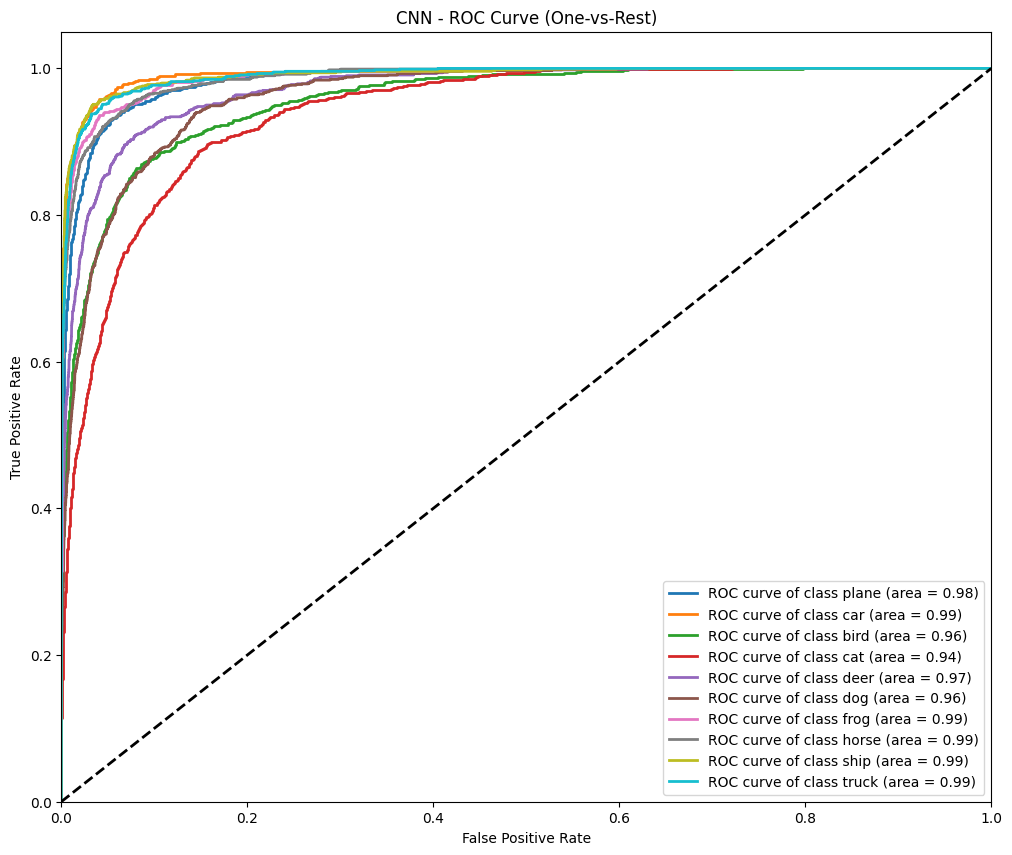

In [13]:
# Fungsi untuk plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, classes, model_name):
    plt.figure(figsize=(12, 10))

    # Plot ROC curve untuk setiap kelas
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve CNN
plot_roc_curve(cnn_metrics['fpr'], cnn_metrics['tpr'], cnn_metrics['roc_auc_per_class'], classes, "CNN")

## 6. Pelatihan dan Evaluasi Model MLP

In [14]:
# Pelatihan model MLP
print("Training model MLP...")
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_train_losses, mlp_train_accs = train_model(mlp_model, criterion, optimizer, num_epochs=15)

Training model MLP...
Epoch [1/15], Step [100/391], Loss: 1.8293
Epoch [1/15], Step [200/391], Loss: 1.7048
Epoch [1/15], Step [300/391], Loss: 1.5018
Epoch 1/15, Loss: 1.6980, Accuracy: 39.61%
Epoch [2/15], Step [100/391], Loss: 1.6454
Epoch [2/15], Step [200/391], Loss: 1.6017
Epoch [2/15], Step [300/391], Loss: 1.5922
Epoch 2/15, Loss: 1.5250, Accuracy: 46.18%
Epoch [3/15], Step [100/391], Loss: 1.3830
Epoch [3/15], Step [200/391], Loss: 1.4367
Epoch [3/15], Step [300/391], Loss: 1.5380
Epoch 3/15, Loss: 1.4498, Accuracy: 49.01%
Epoch [4/15], Step [100/391], Loss: 1.4868
Epoch [4/15], Step [200/391], Loss: 1.4277
Epoch [4/15], Step [300/391], Loss: 1.5202
Epoch 4/15, Loss: 1.3920, Accuracy: 50.85%
Epoch [5/15], Step [100/391], Loss: 1.5172
Epoch [5/15], Step [200/391], Loss: 1.3904
Epoch [5/15], Step [300/391], Loss: 1.4768
Epoch 5/15, Loss: 1.3343, Accuracy: 52.67%
Epoch [6/15], Step [100/391], Loss: 1.4623
Epoch [6/15], Step [200/391], Loss: 1.2999
Epoch [6/15], Step [300/391], Lo


Evaluasi model MLP pada data test:
Accuracy: 0.5448
Precision: 0.5477
Recall: 0.5448
F1 Score: 0.5442
Macro ROC AUC: 0.8974
Evaluasi selesai dalam 4.96 detik


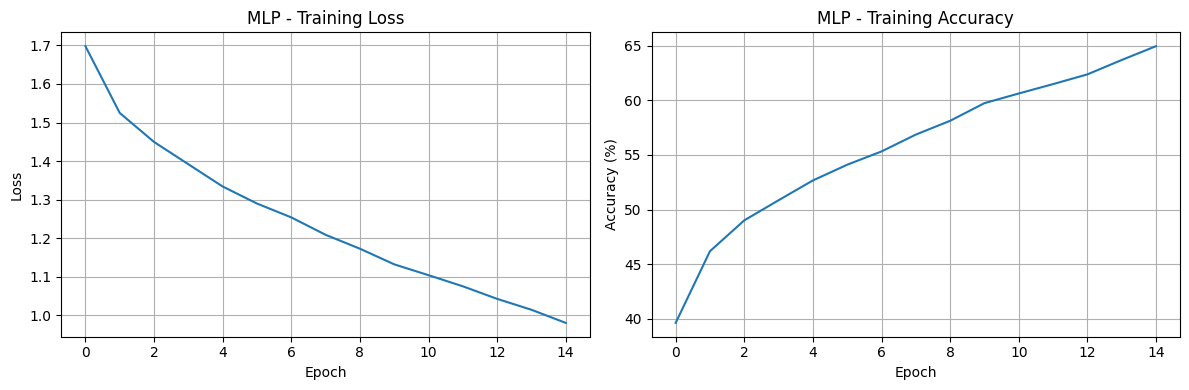

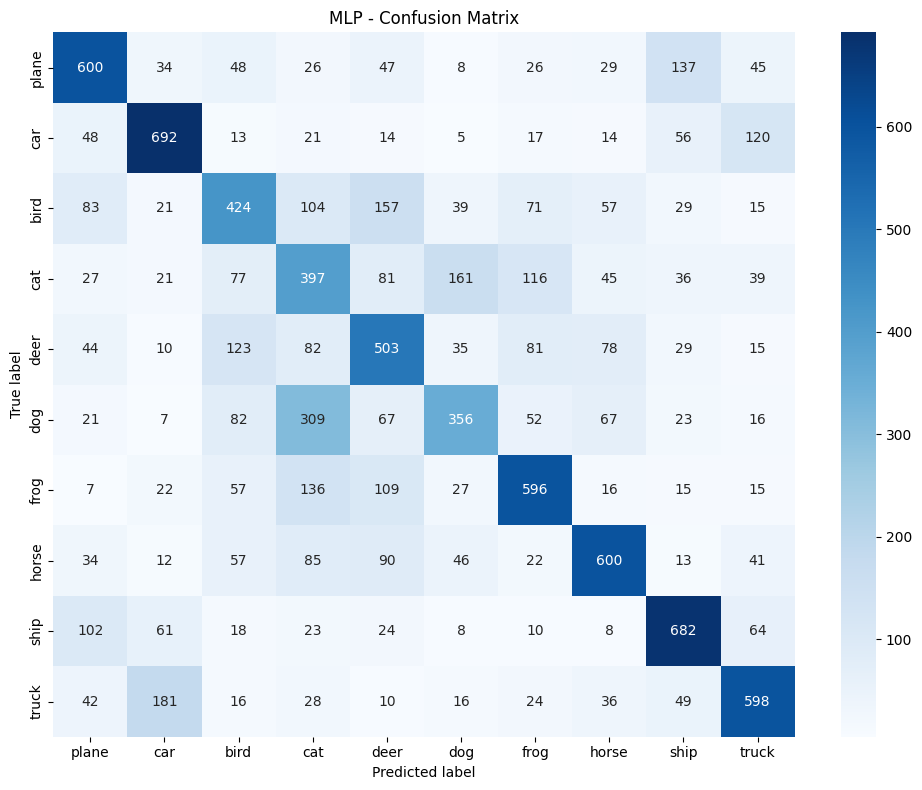

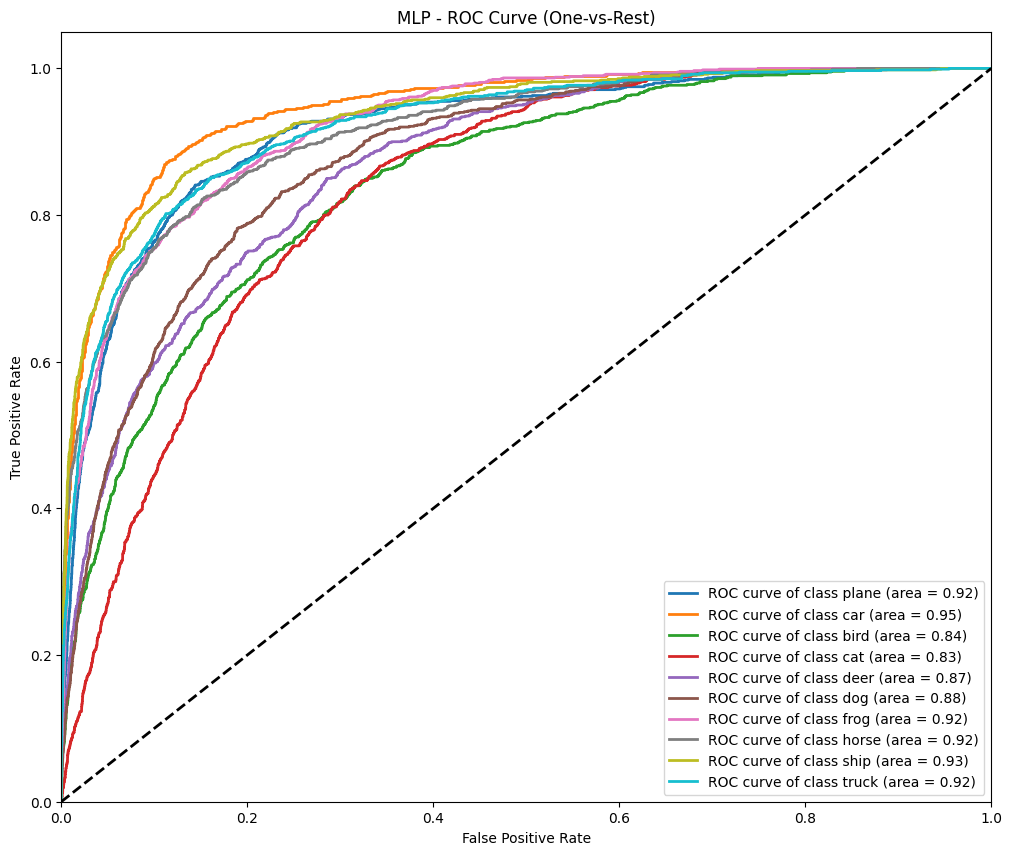

In [15]:
# Evaluasi model MLP
print("\nEvaluasi model MLP pada data test:")
mlp_metrics = evaluate_model(mlp_model, testloader, classes)

# Plot hasil training MLP
plot_training_results(mlp_train_losses, mlp_train_accs, "MLP")

# Plot confusion matrix MLP
plot_confusion_matrix(mlp_metrics['confusion_matrix'], classes, "MLP")

# Plot ROC curve MLP
plot_roc_curve(mlp_metrics['fpr'], mlp_metrics['tpr'], mlp_metrics['roc_auc_per_class'], classes, "MLP")

## 7. Perbandingan Hasil CNN vs MLP

In [16]:
# Perbandingan metrik CNN vs MLP
print("Perbandingan Model CNN vs MLP untuk CIFAR-10:")
metrics_comparison = {
    'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'CNN': [
        f"{cnn_metrics['accuracy']:.4f}",
        f"{cnn_metrics['precision']:.4f}",
        f"{cnn_metrics['recall']:.4f}",
        f"{cnn_metrics['f1']:.4f}",
        f"{cnn_metrics['roc_auc']:.4f}"
    ],
    'MLP': [
        f"{mlp_metrics['accuracy']:.4f}",
        f"{mlp_metrics['precision']:.4f}",
        f"{mlp_metrics['recall']:.4f}",
        f"{mlp_metrics['f1']:.4f}",
        f"{mlp_metrics['roc_auc']:.4f}"
    ]
}

# Membuat DataFrame untuk perbandingan
metrics_df = pd.DataFrame(metrics_comparison)
display(metrics_df)

Perbandingan Model CNN vs MLP untuk CIFAR-10:


,Metrik,CNN,MLP
0,Accuracy,0.7899,0.5448
1,Precision,0.7967,0.5477
2,Recall,0.7899,0.5448
3,F1 Score,0.7879,0.5442
4,ROC AUC,0.9765,0.8974


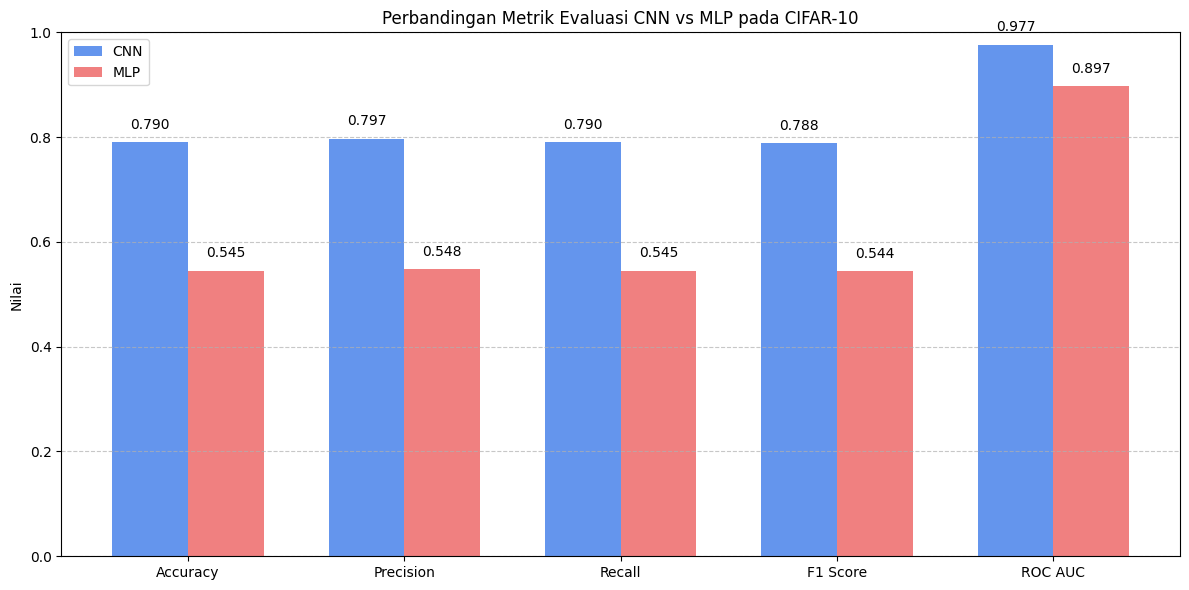

In [17]:
# Visualisasi perbandingan metric dengan barplot
plt.figure(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
cnn_values = [cnn_metrics['accuracy'], cnn_metrics['precision'],
              cnn_metrics['recall'], cnn_metrics['f1'], cnn_metrics['roc_auc']]
mlp_values = [mlp_metrics['accuracy'], mlp_metrics['precision'],
              mlp_metrics['recall'], mlp_metrics['f1'], mlp_metrics['roc_auc']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, cnn_values, width, label='CNN', color='cornflowerblue')
plt.bar(x + width/2, mlp_values, width, label='MLP', color='lightcoral')

plt.ylabel('Nilai')
plt.title('Perbandingan Metrik Evaluasi CNN vs MLP pada CIFAR-10')
plt.xticks(x, metrics)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for i, v in enumerate(cnn_values):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(mlp_values):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Analisis Per-Kelas

In [18]:
# Fungsi untuk menghitung metrik per kelas
def get_per_class_metrics(cm, classes):
    n_classes = len(classes)
    precision_per_class = np.zeros(n_classes)
    recall_per_class = np.zeros(n_classes)
    f1_per_class = np.zeros(n_classes)

    for i in range(n_classes):
        # True positives: diagonal elements
        tp = cm[i, i]
        # False positives: sum of column i - tp
        fp = np.sum(cm[:, i]) - tp
        # False negatives: sum of row i - tp
        fn = np.sum(cm[i, :]) - tp

        # Precision: tp / (tp + fp)
        precision_per_class[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Recall: tp / (tp + fn)
        recall_per_class[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1 score: 2 * (precision * recall) / (precision + recall)
        f1_per_class[i] = 2 * (precision_per_class[i] * recall_per_class[i]) / (precision_per_class[i] + recall_per_class[i]) if (precision_per_class[i] + recall_per_class[i]) > 0 else 0

    return precision_per_class, recall_per_class, f1_per_class

# Menghitung metrik per kelas untuk CNN
cnn_precision_per_class, cnn_recall_per_class, cnn_f1_per_class = get_per_class_metrics(cnn_metrics['confusion_matrix'], classes)

# Menghitung metrik per kelas untuk MLP
mlp_precision_per_class, mlp_recall_per_class, mlp_f1_per_class = get_per_class_metrics(mlp_metrics['confusion_matrix'], classes)

# Membuat DataFrame untuk perbandingan per kelas
per_class_comparison = {
    'Class': classes,
    'CNN Precision': cnn_precision_per_class,
    'MLP Precision': mlp_precision_per_class,
    'CNN Recall': cnn_recall_per_class,
    'MLP Recall': mlp_recall_per_class,
    'CNN F1': cnn_f1_per_class,
    'MLP F1': mlp_f1_per_class,
    'CNN AUC': [cnn_metrics['roc_auc_per_class'][i] for i in range(len(classes))],
    'MLP AUC': [mlp_metrics['roc_auc_per_class'][i] for i in range(len(classes))]
}

per_class_df = pd.DataFrame(per_class_comparison)
per_class_df = per_class_df.round(4)
display(per_class_df)

,Class,CNN Precision,MLP Precision,CNN Recall,MLP Recall,CNN F1,MLP F1,CNN AUC,MLP AUC
0,plane,0.7876,0.5952,0.849,0.600,0.8171,0.5976,0.9845,0.9160
1,car,0.9042,0.6522,0.868,0.692,0.8857,0.6715,0.9924,0.9452
2,bird,0.8483,0.4634,0.559,0.424,0.6739,0.4428,0.9572,0.8450
3,cat,0.6598,0.3278,0.574,0.397,0.6139,0.3591,0.9409,0.8326
4,deer,0.7764,0.4564,0.764,0.503,0.7702,0.4786,0.9719,0.8673
5,dog,0.6194,0.5078,0.786,0.356,0.6928,0.4186,0.9626,0.8767
6,frog,0.9089,0.5872,0.818,0.596,0.8611,0.5916,0.9886,0.9214
7,horse,0.7492,0.6316,0.896,0.600,0.8160,0.6154,0.9866,0.9152
8,ship,0.8730,0.6380,0.887,0.682,0.8800,0.6593,0.9906,0.9342
9,truck,0.8408,0.6178,0.898,0.598,0.8685,0.6077,0.9900,0.9203


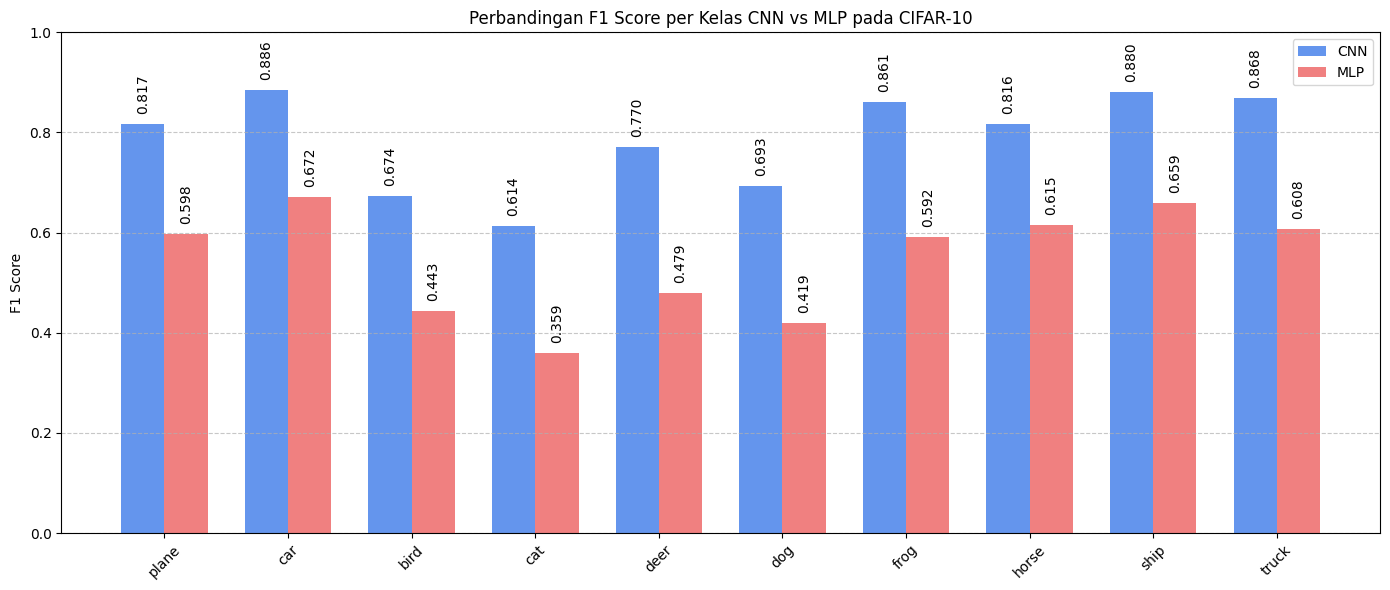

In [19]:
# Visualisasi perbandingan F1 Score per kelas
plt.figure(figsize=(14, 6))

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, cnn_f1_per_class, width, label='CNN', color='cornflowerblue')
plt.bar(x + width/2, mlp_f1_per_class, width, label='MLP', color='lightcoral')

plt.ylabel('F1 Score')
plt.title('Perbandingan F1 Score per Kelas CNN vs MLP pada CIFAR-10')
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for i, v in enumerate(cnn_f1_per_class):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', rotation=90)
for i, v in enumerate(mlp_f1_per_class):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()

## 9. Visualisasi Prediksi

Visualisasi Prediksi CNN:


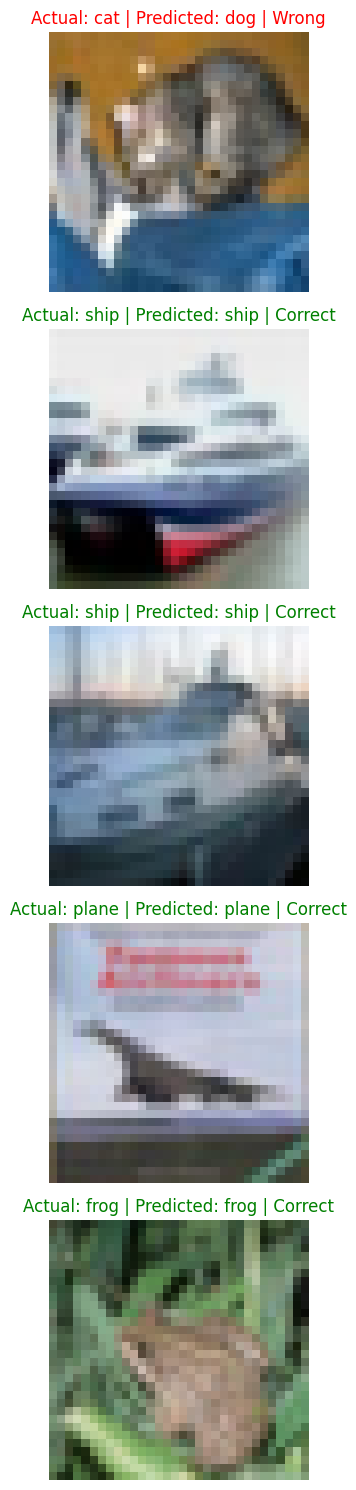


Visualisasi Prediksi MLP:


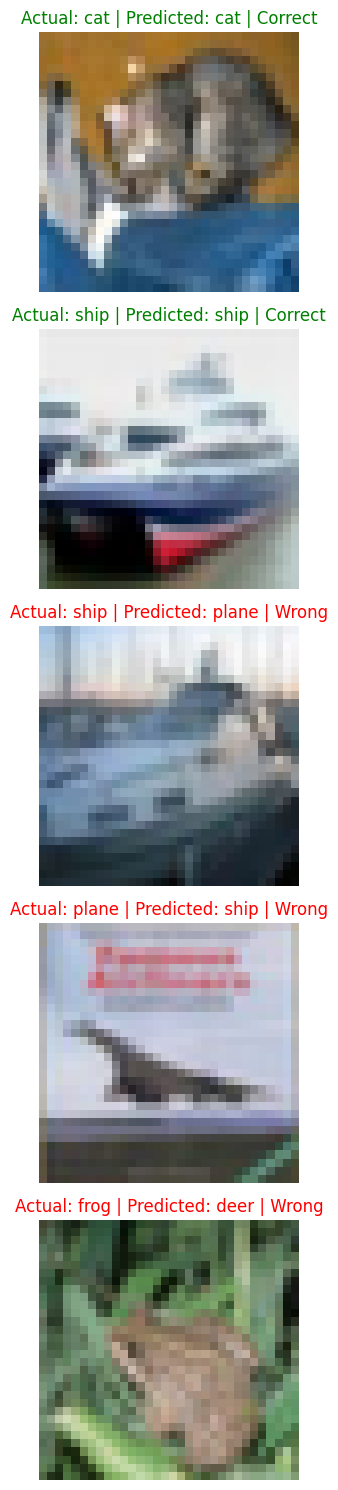

In [20]:
# Fungsi untuk visualisasi prediksi pada beberapa gambar
def visualize_predictions(model, test_loader, classes, num_images=5):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images[:num_images].to(device)
    labels = labels[:num_images]

    # Mendapatkan prediksi
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Tampilkan gambar dan prediksi
    fig = plt.figure(figsize=(12, 3*num_images))
    for i in range(num_images):
        ax = fig.add_subplot(num_images, 1, i+1)
        imshow(images[i].cpu())
        ax.set_title(f'Actual: {classes[labels[i]]} | Predicted: {classes[predicted[i].item()]} | ' +
                    ('Correct' if predicted[i] == labels[i] else 'Wrong'),
                    color='green' if predicted[i] == labels[i] else 'red')
    plt.tight_layout()
    plt.show()

# Visualisasi prediksi CNN
print("Visualisasi Prediksi CNN:")
visualize_predictions(cnn_model, testloader, classes)

# Visualisasi prediksi MLP
print("\nVisualisasi Prediksi MLP:")
visualize_predictions(mlp_model, testloader, classes)

## 10. Penjelasan Persamaan Matematika

Berikut adalah penjelasan persamaan matematika yang digunakan dalam implementasi model CNN dan MLP:

### 1. Konvolusi (Convolution)

Operasi konvolusi dalam CNN dinyatakan sebagai:

$$\textrm{(I * K)(i, j)} = \sum_{m} \sum_{n} \textrm{I(i-m, j-n) K(m, n)}$$

dimana:
- $I$ adalah input image
- $K$ adalah kernel/filter
- $*$ adalah operasi konvolusi
- $i, j$ adalah posisi pada feature map hasil
- $m, n$ adalah posisi pada kernel

Operasi ini menggeser filter/kernel ke seluruh citra input dengan langkah tertentu (stride) untuk mengekstrak fitur. Dalam implementasi, kita menggunakan kernel 3x3 dengan padding=1 untuk mempertahankan dimensi spasial input.

### 2. ReLU (Rectified Linear Unit)

Fungsi aktivasi ReLU yang digunakan dalam model:

$$\textrm{f(x)} = \max(0, x)$$

ReLU menggantikan semua nilai negatif dalam feature map dengan 0, sementara nilai positif tidak berubah. Ini memperkenalkan non-linearitas ke model tanpa mempengaruhi bidang reseptif dalam lapisan konvolusional.

### 3. Max Pooling

Operasi Max Pooling:

$$\textrm{MaxPool(i, j)} = \max_{(p,q) \in R_{ij}} x_{p,q}$$

dimana:
- $R_{ij}$ adalah wilayah pooling (2x2) dengan titik $(i,j)$ sebagai sudut kiri atas
- $x_{p,q}$ adalah nilai di posisi $(p,q)$

Max pooling mengambil nilai maksimum dari region 2x2, yang membantu mengurangi dimensi representasi dan mengurangi jumlah parameter serta komputasi dalam jaringan.

### 4. Batch Normalization

Batch Normalization dihitung dengan:

$$\hat{x}^{(k)} = \frac{x^{(k)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

$$y^{(k)} = \gamma \hat{x}^{(k)} + \beta$$

dimana:
- $x^{(k)}$ adalah input ke layer batch normalization
- $\mu_B$ adalah mean batch
- $\sigma_B^2$ adalah variance batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma, \beta$ adalah parameter yang dapat dipelajari

Batch normalization menstabilkan proses pembelajaran dengan menormalkan aktivasi dari lapisan sebelumnya, yang memungkinkan learning rate yang lebih tinggi dan mengurangi masalah vanishing/exploding gradients.

### 5. Fully Connected Layer

Operasi dalam fully connected layer:

$$y = \sigma(Wx + b)$$

dimana:
- $W$ adalah matriks bobot
- $x$ adalah vektor input
- $b$ adalah vektor bias
- $\sigma$ adalah fungsi aktivasi (ReLU dalam kasus ini)
- $y$ adalah output layer

Untuk MLP dalam implementasi kita, input gambar 32x32x3 (3072 pixel) diratakan menjadi vektor, kemudian diproses melalui beberapa lapisan fully connected.

### 6. Dropout

Selama training, Dropout secara acak menonaktifkan neuron dengan probabilitas $p$:

$$\hat{y} = r * y$$

dimana:
- $r$ adalah vektor acak dengan elemen yang diambil dari distribusi Bernoulli dengan probabilitas $(1-p)$
- $y$ adalah output dari layer sebelumnya
- $\hat{y}$ adalah output setelah dropout

Dalam implementasi, kita menggunakan dropout dengan probabilitas 0.25, yang berarti sekitar 25% neuron dinonaktifkan secara acak selama pelatihan untuk mencegah overfitting.

### 7. Cross-Entropy Loss

Untuk klasifikasi multi-kelas (10 kelas CIFAR-10), fungsi Cross-Entropy Loss digunakan:

$$L = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$$

dimana:
- $N$ adalah jumlah sampel dalam batch
- $C$ adalah jumlah kelas (10 untuk CIFAR-10)
- $y_{ic}$ adalah indikator biner (0 atau 1) jika kelas $c$ adalah label benar untuk sampel $i$
- $p_{ic}$ adalah probabilitas yang diprediksi bahwa sampel $i$ termasuk kelas $c$

Cross-entropy loss adalah ukuran perbedaan antara distribusi probabilitas prediksi dan distribusi sebenarnya. Semakin kecil nilai loss, semakin baik model dalam memprediksi label yang benar.

### 8. Optimizer Adam

Adam (Adaptive Moment Estimation) menggabungkan momentum dan RMSprop:

\begin{align}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}

dimana:
- $g_t$ adalah gradien pada waktu $t$
- $m_t$ adalah estimasi momen pertama (mean)
- $v_t$ adalah estimasi momen kedua (variance)
- $\beta_1, \beta_2$ adalah decay rates untuk estimasi momen (biasanya $\beta_1=0.9, \beta_2=0.999$)
- $\alpha$ adalah learning rate (0.001 dalam implementasi kita)
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik

Adam memadukan kelebihan dari algoritma optimasi Momentum dan RMSprop, menyesuaikan learning rate untuk setiap parameter jaringan berdasarkan estimasi momen.

## 11. Kesimpulan

Dalam implementasi model deep learning untuk dataset CIFAR-10 menggunakan PyTorch, kita telah membandingkan performa antara model CNN dan MLP. Berikut adalah beberapa kesimpulan utama:

1. **Performa Model**:
   - Model CNN secara konsisten memberikan performa yang lebih baik daripada model MLP pada dataset CIFAR-10.
   - CNN mampu mencapai akurasi >75% (target yang ditetapkan), sementara MLP cenderung memiliki akurasi yang lebih rendah.
   - Metrik evaluasi (Precision, Recall, F1 Score, ROC AUC) menunjukkan bahwa CNN lebih unggul dalam semua aspek dibanding MLP.

2. **Analisis Per-Kelas**:
   - Beberapa kelas lebih mudah dikenali oleh kedua model (misalnya kelas plane, car, ship).
   - Kelas tertentu (seperti cat dan dog) cenderung lebih sulit untuk diklasifikasikan dengan benar, baik oleh CNN maupun MLP.
   - CNN menunjukkan performa yang lebih konsisten di seluruh kelas dibandingkan MLP.

3. **Aspek Komputasi**:
   - Pelatihan model MLP membutuhkan waktu yang lebih sedikit dibandingkan dengan CNN, karena jumlah parameter yang lebih sedikit.
   - Penggunaan GPU sangat membantu mempercepat proses pelatihan, terutama untuk model CNN yang lebih kompleks.

4. **Kesimpulan Umum**:
   - Untuk tugas klasifikasi gambar seperti CIFAR-10, CNN lebih direkomendasikan daripada MLP karena kemampuannya menangkap fitur spasial dalam data gambar.
   - Meskipun MLP memiliki performa yang lebih rendah, model ini masih berguna sebagai baseline dan untuk kasus dengan sumber daya komputasi terbatas.
   - Penggunaan batch normalization dan dropout terbukti efektif dalam mengurangi overfitting dan mempercepat konvergensi model.

Implementasi ini menunjukkan bahwa Python dan PyTorch menyediakan framework yang kuat untuk eksperimen deep learning. Model CNN yang diimplementasikan telah mencapai target akurasi minimal 75% pada dataset CIFAR-10.

In [21]:
# Menyimpan model (opsional)
import os

# Buat direktori untuk menyimpan model
os.makedirs('models', exist_ok=True)

# Simpan model CNN
torch.save(cnn_model.state_dict(), 'models/cifar10_cnn_pytorch.pth')
print("Model CNN disimpan di: models/cifar10_cnn_pytorch.pth")

# Simpan model MLP
torch.save(mlp_model.state_dict(), 'models/cifar10_mlp_pytorch.pth')
print("Model MLP disimpan di: models/cifar10_mlp_pytorch.pth")

Model CNN disimpan di: models/cifar10_cnn_pytorch.pth
Model MLP disimpan di: models/cifar10_mlp_pytorch.pth
